# FINM 33150 - Quantitative Trading Project
## Quantative Value Strategy
### <u>Authors:</u>
* Da Si
* Anand Krishnakumar
* Paul Stevenson
<br/>
<hr style='height:5px'/>

### NOTES
* <b>To run this notebook yourself, you have to enter your own Quandl API key in the appropriate section below</b>
* This code is dependent on the data files that were included along with this Python notebook being present in the same working directory
* This code also generated a CSV file in the current working directory named <i>executed_strategy_data.csv</i> which contains the capital, profit, return and other such relevant data on a yearly basis

In [2]:
%matplotlib inline
import Quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import dateutil.parser as parser
import statistics
import csv

In [352]:
# Update this variable with your own Quandl API key
key= "vx6HjWthadEgspXUcbp5"

#### Utility Functions

In [353]:
# remove the unnecessary information from ticker column
def clean_ticker(dataframe):
    replacement = []
    for c in dataframe['Ticker'].values:
        ticker,a,b = c.split(' ')
        replacement.append(ticker)
    dataframe['Ticker'] = replacement
    return dataframe

In [354]:
def clean_data(data):
    # delete first row since it is useless
    data = data.ix[1:]
    # remove the unnecessary information from ticker column
    data = clean_ticker(data)
    # set index to ticker
    data = data.set_index(data.Ticker)
    # replace -- with NaN
    data = data.replace('--',np.nan)
    # drop unuseful columns
    data = data.drop(['Ticker','Weight','Shares'],1)
    # remove the blank space at the end of the column names
    data.columns = [i.rstrip() for i in data.columns.values]
    return data

In [355]:
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

In [356]:
# import all EOD tickers
EOD = pd.DataFrame.from_csv('EOD-datasets-codes.csv')

#### Screening Functions

In [357]:
def stock_screen(year, marketCap):
    """
    year: from 2000 to 2015
    marketCap: in hundred millions
    """
    raw_data = pd.read_excel(str(year)+'.xlsx')
    data = clean_data(raw_data)
    # for issurance of common stocks, we assume NaN is 0
    data = data.replace({'Issuance of Common Stocks T12M':np.nan},0)
    # get common tickers that are in Russell 3000 and EOD database
    commonTickers = list(set(EOD.index.tolist()) & set(data.index.tolist()))
    commonTickers.sort()
    # update data
    data = data.loc[commonTickers]
    # construct dataframe of all screening factors we need and calculate those values
    rank = pd.DataFrame(index = data.index, columns = ['MarketCap','Z_score','EV_EBITDA','F_score'])
    rank['MarketCap'] = data['Market Cap']
    # Z score
    rank['Z_score'] = data['AZS']
    # EV/EBITDA
    rank['EV_EBITDA'] = data['EV']/data['EBITDA T12M']
    rank.loc[rank['EV_EBITDA']<=0,'EV_EBITDA'] = np.nan
    # F score
    rank['F_score'] = 0 + (data['ROA LF'] > 0) + (data['CFO T12M'] > 0) + (data['D_ROA'] > 0) +\
        (data['CFO T12M']/data['Tot Assets LF'] >data['ROA LF'])+(data['Issuance of Common Stocks T12M'] <= 0)+\
        (data['D_LEVER'] < 0) +(data['D_LIQUID'] > 0)+(data['D_MARGIN'] > 0) +(data['D_TURN'] > 0)
    # screen by marketcap, Z score > 2.99
    rank = rank[(rank['MarketCap']>marketCap*pow(10,8)) & (rank['Z_score'] > 2.99)]
    # sort qualified stocks using scores
    rank = rank.loc[rank['EV_EBITDA']>=0,:]
    rank['Score'] = rank['F_score'].rank(ascending = False) + rank['EV_EBITDA'].rank()
    return rank.sort_values(by = 'Score')

In [358]:
 def sector_screen(rank,n,percent):
    """
    takes the rank of screened sctocks and return the first n stocks with no sector that has more than (n * percent) stocks
    rank: DataFrame of stocks, output from stock_screen combined with sector information
    n: number of stocks wanted
    percent: max limit of sector in percentage
    """
    count = rank.groupby(['sector']).count()
    limit = n*percent
    counter = dict((key,0) for key in count.index)
    stockList = []
    for i in rank.index:
        if rank.loc[i,'sector'] in counter.keys():
            # check if number of stock in certain sector exceeds the limit
            if counter[rank.loc[i,'sector']]<=limit:
                stockList.append(i)
                counter[rank.loc[i,'sector']]+=1
        else:
            # if sector is NaN add it anyway
            stockList.append(i)
        # check total number of stocks
        if len(stockList) == n:
            break
    return stockList

#### Quantitative Strategy

In [359]:
def strat(initial_capital, borrowed_capital, min_market_cap, portfolio_size, max_sector_weight, \
          start_date, end_date, hedge_ticker, yearly_profits, yearly_returns):
    """
    initial_capital: initial equity capital
    borrowed_capital: amount borrowed to leverage our investment
    min_market_cap: minimum marketcap of company
    portfolio_size: number of stocks from rank to hold each year
    max_sector_weight: threshold for each sector eg: 0.25 means no more than 25% in terms of number of stock for each sector
    start_date, end_date: start & end dates for strategy
    hedge_ticker: the security we use to hedge market risk
    yearly_profits: output vector that will be filled in to contain the annual profits
    yearly_returns: output vector that will be filled in to contain the annual returns
    """
    # set inital invested capital
    invested_capital = initial_capital + borrowed_capital
    # create market-to-market value as dataframe
    MTM = pd.DataFrame()
    
    start_year = parser.parse(start_date).year
    end_year = parser.parse(end_date).year
    
    # Write also write the strategy's executed trade data to a CSV file.
    with open('executed_strategy_data.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['year', 'initial_capital', 'invested_capital', 'hedge_size', 'year_end_MTM', 'profit', 'return'])
    
        for year in range(start_year, end_year):
            # Get all stocks that pass the screenin criteria. The results are ordered by rank.
            rank = stock_screen(year, min_market_cap)

            # Add sector information for each stock in our screened list of candidates
            sector = pd.read_excel(str(year)+'_sector.xlsx')
            sector = clean_data(sector)
            rank['sector'] = sector.loc[rank.index,'GICS Sector']

            # Apply sector screen to ranked stocks
            stockList = sector_screen(rank,portfolio_size,max_sector_weight)
            stockList = ['EOD/'+ s +'.11' for s in stockList]
            stockList.append(hedge_ticker+'.11')
            # Get stock daily prices and 12M LIBOR from Quandl
            start = str(year)+'-12-31'
            end = str(year+1)+'-12-30'
            stock = Quandl.get(stockList,trim_start=start,trim_end=end, authtoken=key)
            stock = stock.fillna(value =1)
            libor = Quandl.get("FRED/USD12MD156N",trim_start=start,trim_end=end, authtoken=key)
            hedge_size = invested_capital/stock.iloc[0][-1] # Number of shares of hedge security to short
            # We use a hedge ratio of 0.5 and so we increase our invested capital by 100%
            invested_capital = 2 * invested_capital

            # calculate shares for each position for an equal dollar amount invested
            weight = invested_capital / portfolio_size / stock.iloc[0]
            weight[-1] = -hedge_size 
            # transform into pandas Series for matrix multiplication 
            weight = pd.Series(index = stock.columns, data = weight.tolist())
            # update mark-to-market value for each additional year
            MTM = pd.concat([MTM,stock.dot(weight)])
            stock = None
            weight = None
            # Determine new invested capital after repaying interest on loan at 12M LIBOR + 50 bps
            invested_capital = MTM.iloc[-1][0] - borrowed_capital * (libor.iloc[0]['VALUE'] + 0.5)/100

            # Compute yearly profits & returns and add to the the output vector being accumulated
            profit = invested_capital - borrowed_capital - initial_capital
            yearly_profits.append(profit)
            yearly_returns.append(profit/initial_capital)

            writer.writerow([year+1, initial_capital, invested_capital, hedge_size, MTM.iloc[-1][0], profit, profit/initial_capital])
            # Update our initial capital to reflect our actual equity in the strategy
            initial_capital = initial_capital + profit
    return MTM

#### Execute the strategy

In [360]:
# Set Strategy parameters
initial_capital = pow(10,6)
borrowed_capital = initial_capital
start_date = '2000-12-31'
end_date = '2015-12-31'
min_market_cap = 2.5 # in 100 millions USD
portfolio_size = 40
max_sector_weight = 0.25
benchmark_ticker = 'EOD/THRK'
hedge_ticker = 'EOD/IWV'
yearly_profits = []
yearly_returns = []

# Retrieve benchmark prices
benchmark_data = Quandl.get(benchmark_ticker +'.11', trim_start=start_date, trim_end=end_date, authtoken=key)

# Run the trading strategy
MTM = strat(initial_capital, borrowed_capital, min_market_cap, portfolio_size, max_sector_weight, \
            start_date, end_date, hedge_ticker, yearly_profits, yearly_returns)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Plots

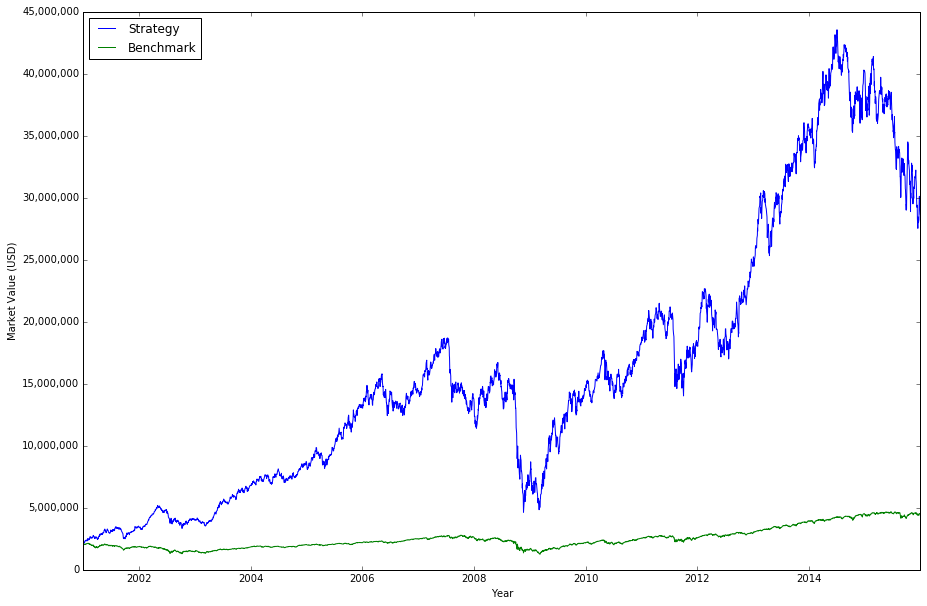

In [382]:
# Plot the market value of the strategy portfolio and that of an equivalent investment in the benchmark
fig, ax1 = plt.subplots(figsize=(15, 10))
plt.plot(MTM[0], label = 'Strategy')
plt.hold(True)
plt.plot(benchmark_data.Adj_Close * ((initial_capital+borrowed_capital)/benchmark_data.iloc[0]['Adj_Close']), label = 'Benchmark')
plt.legend(loc='upper left')
ax1.set_xlabel('Year')
ax1.set_ylabel('Market Value (USD)')
ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

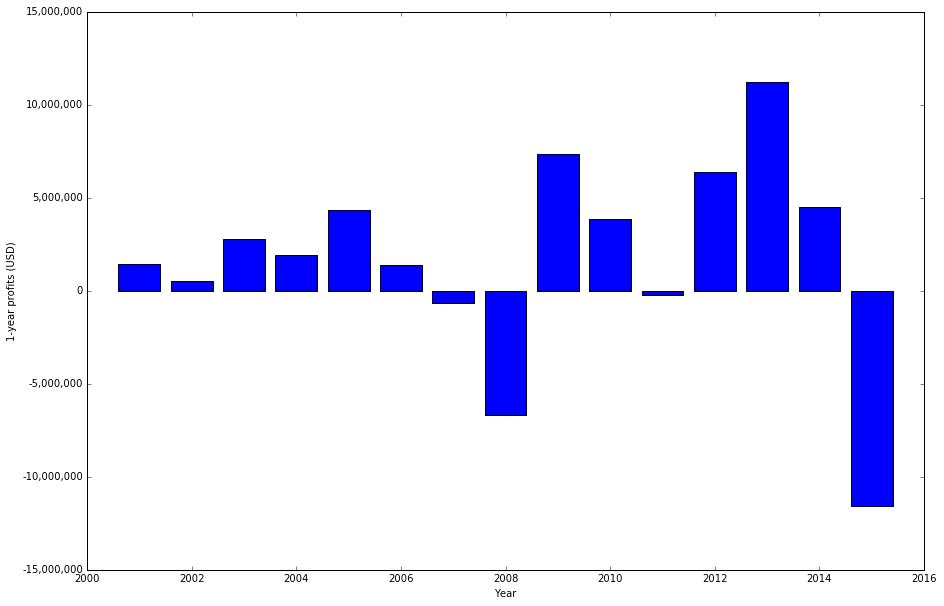

In [373]:
# Plot the annual profits of the strategy
fig, ax1 = plt.subplots(figsize=(15, 10))
xValues = range(parser.parse(start_date).year+1, parser.parse(end_date).year+1)
ax1.bar(xValues, yearly_profits, align='center')
ax1.set_xlabel('Year')
ax1.set_ylabel('1-year profits (USD)')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

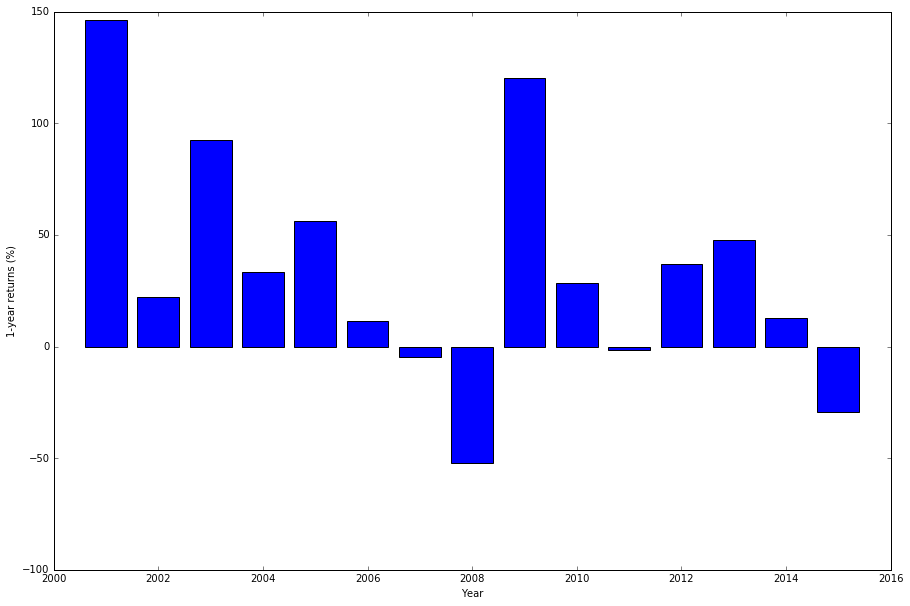

In [363]:
# Plot the annual returns of the strategy
fig, ax1 = plt.subplots(figsize=(15, 10))
xValues = range(parser.parse(start_date).year+1, parser.parse(end_date).year+1)
ax1.bar(xValues, np.array(yearly_returns)*100, align='center')
ax1.set_xlabel('Year')
ax1.set_ylabel('1-year returns (%)')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

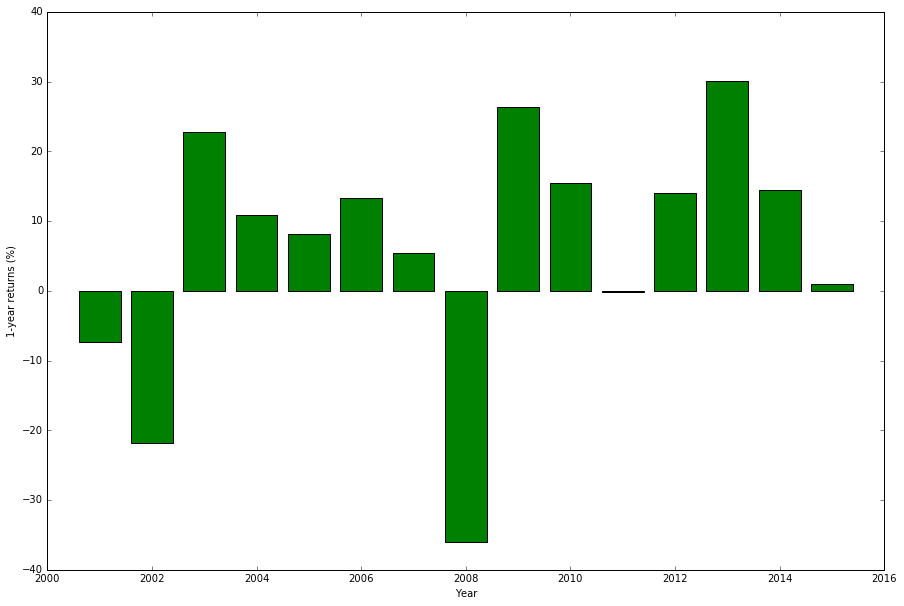

In [364]:
# Compute the annual returns of the benchmark
benchmark_yearly_returns = []
for year in range(parser.parse(start_date).year+1, parser.parse(end_date).year+1):
    benchmark_yearly_returns.append(benchmark_data[benchmark_data.index.year == year].Adj_Close[-1]/benchmark_data[benchmark_data.index.year == year].Adj_Close[0]-1)

# Plot the annual returns of the benchmark
fig, ax1 = plt.subplots(figsize=(15, 10))
xValues = range(parser.parse(start_date).year+1, parser.parse(end_date).year+1)
ax1.bar(xValues, np.array(benchmark_yearly_returns)*100, color='g', align='center')
ax1.set_xlabel('Year')
ax1.set_ylabel('1-year returns (%)')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

#### Statistics

In [365]:
# Compute the maximum drawdown, Sharpe and Sortino ratios for the strategy
print('Maximum drawdown (as a fraction): ', max_drawdown(MTM[0]))
excess_returns = np.array(yearly_returns) - np.array(benchmark_yearly_returns)
mean_excess_return = statistics.mean(excess_returns)
std_dev_excess_return = statistics.stdev(excess_returns)
Sharpe_ratio = mean_excess_return/std_dev_excess_return
print('Sharpe ratio: ', Sharpe_ratio)

downside_returns = excess_returns[excess_returns < 0]
if(downside_returns.size > 0):
    Sortino_ratio = mean_excess_return/statistics.stdev(downside_returns)
    print('Sortino ratio: ', Sortino_ratio)

Maximum drawdown (as a fraction):  0.751794612095
Sharpe ratio:  0.588985088984
Sortino ratio:  2.42715790561
